# BMIN 5200 Foundations of Artificial Intelligence in Health

Assignment 3: Expert Systems in clipspy

In [ ]:
# mount the google drive - this is necessary in every Colab notebook to use the virtualenv
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!pip install clipspy

In [ ]:
import clips
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/bmin5200-2023/src")
from clips_util import print_facts, print_rules, print_templates, build_read_assert, build_print_out

In [ ]:
# create the CLIPS environment
env = clips.Environment()

# HIV Clinical Trial Enrollment System

In this problem set, you will use [clipspy](https://clipspy.readthedocs.io/en/latest/index.html) to complete implementation of an Expert System that determines participant eligbility for an HIV clinical trial. The system first evaluates inclusion criteria. If __all__ of the inclusion criteria are satisfied, the system then evaluates exclusion criteral. If __any__ of the exclusion criteria are met, the system determines that the participant is __not eligible__, otherwise, the system determines that the participant is eligible.

Conceptually, the system logic flow is given in this figure:

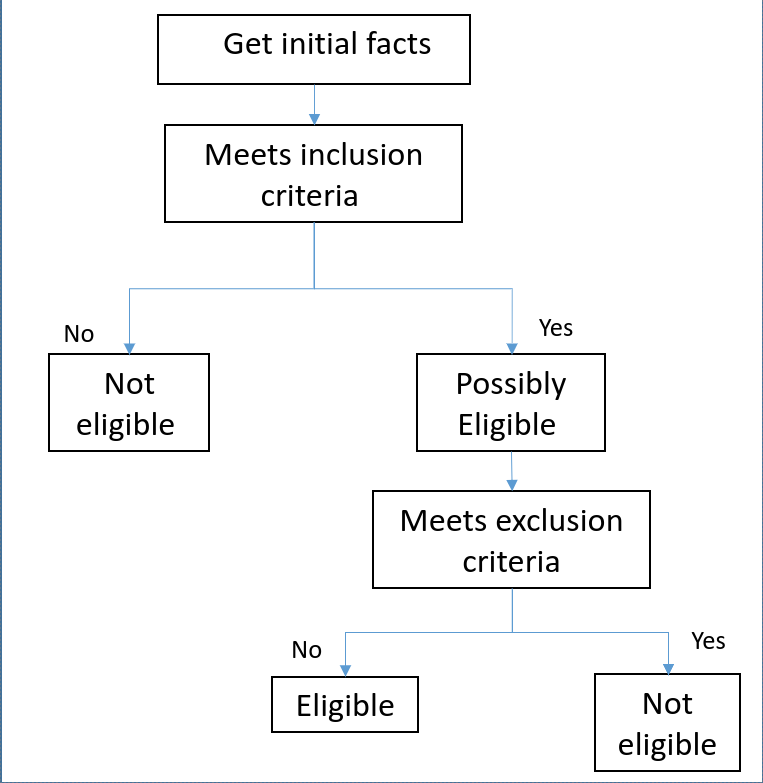

The "Meets inclusion criteria" box can be expanded as in this figure:

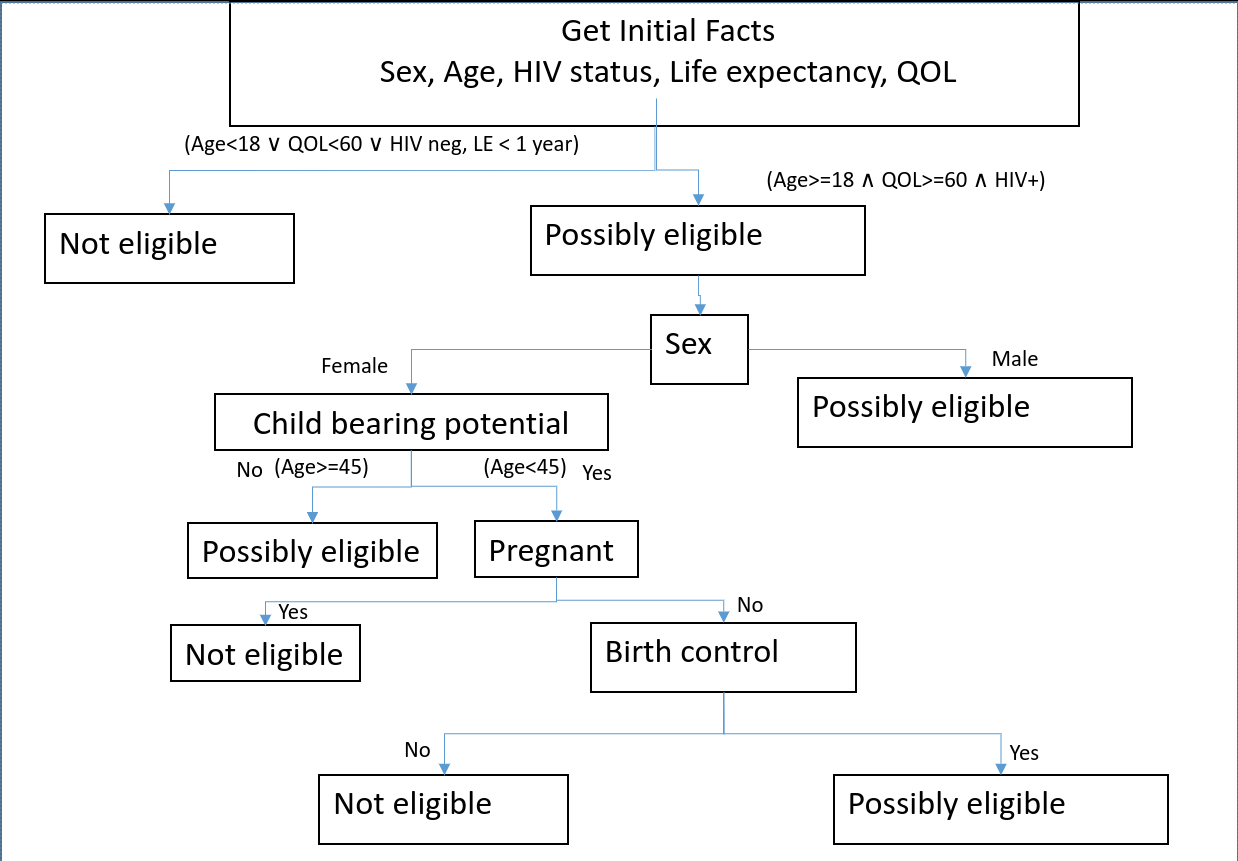

In words, the inclusion criteria are:

- Patient is at least 18
- Patient has a positive diagnosis for HIV based on ELISA
- Patient life expectancy >= 1 year
- Karnofsky Performance Status (quality of life) >= 60
- If the patient is a woman of child bearing years (age <45) and she is on birth control and is not pregnant (a negative serum birth control pregnancy test).

The "Meets exclusion criteria" box can be expanded as in this figure:

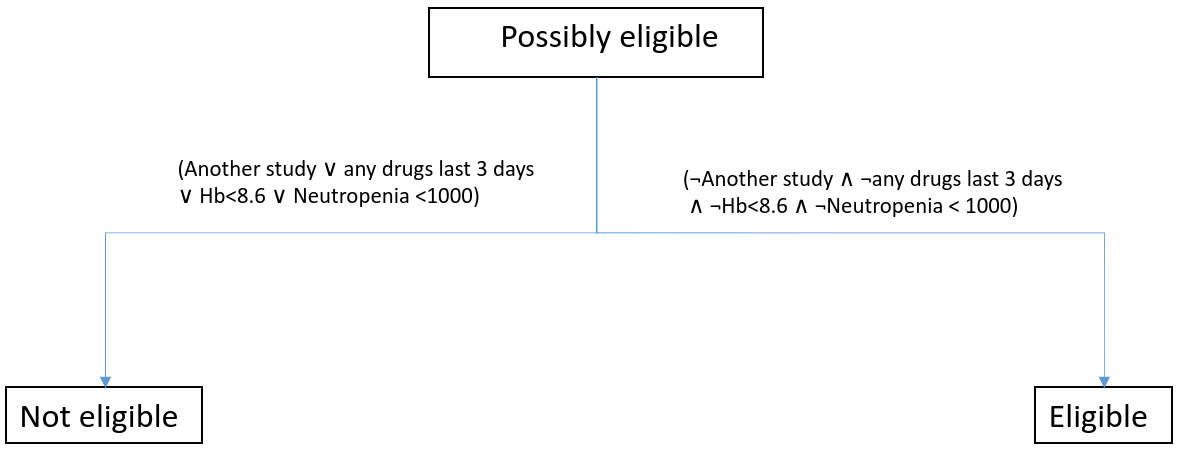

The exclusion criteria are:

- Patient cannot be any other study
- Patient has not taken any drugs in the last 3 days
- Patient does not have a Hemoglobin count < 8.6 g/dl
- Patient does not have a neutrophil count <1000 cells/mm

Most of the system has been implemented in the remainder of this IPython notebook. The setup assumes that each time you want to use the system to evaluate a patient for trial eligibility, that the required `deffacts` have been built (as implemented in this notebook) and that the environment has been reset (i.e., `env.reset()` has been executed). You should review the provided code for understanding.

__For this assignment:__, You are tasked with implementing three `defrules`. The notebook cells where these should be implemented are indicated as Problem 1, Problem 2, and Problem 3. You will _not_ need to create any `deftemplates` for `deffacts`. However, you will need to refer to several of the `templates` and `slot` values in your `defrules`.

# Templates


## Inclusion Criteria Fact Templates

This section defines and builds all of the templates that are needed to track and evalute facts associated with inclusion criteria.

In [ ]:
# basic patient information
DEFTEMPLATE_PATIENT = """
(deftemplate patient
    (slot name_is (type STRING))
    (slot age_is (type INTEGER)
        (range 0 130))
    (slot sex_is (type SYMBOL)
        (allowed-symbols male female)))
"""
env.build(DEFTEMPLATE_PATIENT)

# participant life expectancy
DEFTEMPLATE_LIFE_EXPECTANCY = """
(deftemplate life_expect
    (slot years_expected_is (type INTEGER))
)
"""
env.build(DEFTEMPLATE_LIFE_EXPECTANCY)

# participant Karnofsky quality of life score
DEFTEMPLATE_KARNOFSKY = """
(deftemplate karnofsky
  (slot performance_status_is (type INTEGER)
    (range 0 100))
)
"""
env.build(DEFTEMPLATE_KARNOFSKY)

# participant HIV ELISA test result
DEFTEMPLATE_HIV = """
(deftemplate hiv_testing
    (slot hiv_elisa_is (type SYMBOL)
        (allowed-symbols positive negative))
)
"""
env.build(DEFTEMPLATE_HIV)

# participant (if female) child bearing age status
DEFTEMPLATE_CHILD_BEARING = """
(deftemplate child_bearing
   (slot of_child_bearing_age (type SYMBOL)
        (allowed-symbols yes no unknown)))
"""
env.build(DEFTEMPLATE_CHILD_BEARING)

# participant pregnancy status
DEFTEMPLATE_PREGNANCY = """
(deftemplate serum_preg
    (slot preg_test_is (type SYMBOL)
        (allowed-symbols positive negative))
)
"""
env.build(DEFTEMPLATE_PREGNANCY)

# participant birth control status
DEFTEMPLATE_BIRTH_CONTROL = """
(deftemplate birth_control
    (slot on_birth_control (type SYMBOL)
        (allowed-symbols yes no))
)
"""
env.build(DEFTEMPLATE_BIRTH_CONTROL)

## Exclusion Criteria Fact Templates

This section defines and builds all of the templates that are needed to track and evalute facts associated with inclusion criteria.

In [ ]:
# participant in another study
DEFTEMPLATE_OTHER_STUDY = """
(deftemplate other_study
    (slot is_other_study_participant (type SYMBOL)
        (allowed-symbols yes no))
)
"""
env.build(DEFTEMPLATE_OTHER_STUDY)

# participant taking any drugs status
DEFTEMPLATE_DRUGS = """
(deftemplate any_drugs
    (slot has_taken_drugs (type SYMBOL)
        (allowed-symbols yes no))
)
"""
env.build(DEFTEMPLATE_DRUGS)

# participant hemoglobin level
DEFTEMPLATE_HEMOGLOBIN = """
(deftemplate hemoglobin
    (slot hemoglobin_count_is (type FLOAT))
)
"""
env.build(DEFTEMPLATE_HEMOGLOBIN)

# participant neutrophil (white blood cell) count
DEFTEMPLATE_NEUTROPHIL = """
(deftemplate neutrophil
    (slot neutrophil_count_is (type FLOAT))
)
"""
env.build(DEFTEMPLATE_NEUTROPHIL)

## Inclusion_Exclustion Criteria Met Fact Templates
This section defines and builds all of the templates that are needed to track and evalute whether inclusion, exclusion, and trial eligibility criteria are met.

In [ ]:
# participant inclusion criteria met status
DEFTEMPLATE_INCLUSION = """
(deftemplate inclusion
    (slot criteria_met (type SYMBOL)
        (allowed-symbols yes no unknown))
)
"""
env.build(DEFTEMPLATE_INCLUSION)

# participant exclusion criteria met status
DEFTEMPLATE_EXCLUSION = """
(deftemplate exclusion
    (slot criteria_met (type SYMBOL)
        (allowed-symbols yes no unknown))
)
"""
env.build(DEFTEMPLATE_EXCLUSION)

# participant trial eligibility status
DEFTEMPLATE_TRIAL_ELIGIBILITY = """
(deftemplate hiv_trial_inclusion
    (slot meets_criteria (type SYMBOL)
    (allowed-symbols yes no unknown possible))
)
"""
env.build(DEFTEMPLATE_TRIAL_ELIGIBILITY)

# Intiliaze Knowledge Base

This section adds the necessary `deffacts`. These include four facts with slot values set to `unknown` to prevent some rules from firing at inappropriate times. As different rules are executed and facts asserted, these slot values will be updated so that, through chaining, other rules will then fire as needed. You should review the already implemented `defrules` carefully to understand how these work.

In [ ]:
# Add deffacts that the inclusion, exclusion, trial eligibility, and child bearing status are all unknown
DEFFCATS_INITIAL_STATUS = """
(deffacts starting_inclusion_exclusion_facts "Set the inclusion criteria met to unknown"
    (hiv_trial_inclusion (meets_criteria unknown))
    (inclusion (criteria_met unknown))
    (exclusion (criteria_met unknown))
    (child_bearing(of_child_bearing_age unknown))
)
"""
env.build(DEFFCATS_INITIAL_STATUS)

# reset the environment to make sure the deffacts are added
env.reset()

# Inference Rules

## Inclusion Criteria Rules

The `defrules` in this section support gathering user input about the patient relative to the inclusion criteria and determining if the inclusion criteria are met. Notice that if the initial criteria (age, Karnofsky quality of life, life expectancy, and HIV status) are not met, no further information is collected as it is already known that trial eligibility will not be satisfied. If the initial inclusion criteria are met, then the value of the patient's sex is requested. If the patient is female, yet more information is requested.

In [ ]:
# These are the prompts that will be displayed to the user when requesting various template:slot inputs.
prompt_map = {
    "patient:name_is": "Enter patient name: ",
    "patient:age_is": "Enter patient age (in years): ",
    "patient:sex_is": "Enter patient sex (male or female): ",
    "life_expect:years_expected_is": "Enter patient life expectancy (in years): ",
    "karnofsky:performance_status_is": "Enter patient Karnofsky Performance Status (integer value): ",
    "hiv_testing:hiv_elisa_is": "Enter patient HIV status based on HIV Elisa test (positive or negative): ",
    "serum_preg:preg_test_is" : "What is the result of patient's pregnancy test (positive or negative)?: ",
    "birth_control:on_birth_control" : "Is the patient on birth control (yes or no)?: ",
    "other_study:is_other_study_participant" : "Is the patient participating in another study (yes or no)?: ",
    "any_drugs:has_taken_drugs" : "Has the patient taken any drugs in the past 3 days? (yes or no): ",
    "hemoglobin:hemoglobin_count_is" : "What is the Hemoglobin count? (provide number (units are grams/dl)): ",
    "neutrophil:neutrophil_count_is" : "What is the Neutrophil count? (provide number (units are cells/mm)): "
}
build_read_assert(env, prompt_map) # see src/clips_util.py for implementation and demos/clips/clips_basics.ipynb for usage

build_print_out(env) # see src/clips_util.py for implementation. This is needed for defrules to print to std in colab

DEFRULE_READ_INITIAL_INCLUSION = """
(defrule reading_input_initial
    =>
    (read_assert patient)
    (read_assert life_expect)
    (read_assert karnofsky)
    (read_assert hiv_testing)
)
"""
env.build(DEFRULE_READ_INITIAL_INCLUSION)

# Determine child bearing age status using forward chaining based on female sex and age
# Only want this to run if the female candidate is not already excluded based on other criteria.
DEFRULE_CHILD_BEARING_AGE = """
(defrule child_bearing_eval "Evaluate for child_bearing age or not for possibly eligible females"
    (logical
    	(patient (age_is ?age) (sex_is female))
    	(test(>= ?age 18))
    	(test(< ?age 45)) ;commonly accepted standard of upper limit of child bearing age of 45

    	(life_expect (years_expected_is ?life_expected))
       (karnofsky (performance_status_is ?karnofsky_score))
    	(test (>= ?life_expected 1))
      	(test (>= ?karnofsky_score 60))
 		(hiv_testing (hiv_elisa_is positive))
 	)

    =>

    (assert (child_bearing(of_child_bearing_age yes)))
)
"""
env.build(DEFRULE_CHILD_BEARING_AGE)


# Get additional information from user if it is determined that participant is a child bearing age female.
# Forward chaining to infer whether a female is still eligible by not being pregnant and having adequate pregnancy prevention
DEFRULE_INPUT_PREG_EVAL = """
(defrule reading_input_preg_eval "Ask for data on patient_pregnancy evaluation and birth control"
        (child_bearing(of_child_bearing_age yes))

        =>

        (read_assert serum_preg)

)
"""
env.build(DEFRULE_INPUT_PREG_EVAL)


# Get additional information from user if it is determined that participant is of child bearing age, female, and not already pregnant
# Supports forward chaining to infer whether a female is still eligible by not being pregnant and having adequate pregnancy prevention
DEFRULE_INPUT_BC = """
(defrule reading_input_birthcontrol_eval "Ask for data on birth control if the patient is of child-bearing age and not pregnant"
    (child_bearing(of_child_bearing_age yes))
    (serum_preg (preg_test_is negative))

    =>

    ;(printout t "Is the patient on birth control (yes or no)?: ")
    ;(assert (birth-control (on-birth-control (read))))

    (read_assert birth_control)
)
"""
env.build(DEFRULE_INPUT_BC)

# ; RULE: Inclusion Criteria Are Not Met
# ; *Forward chaining to determine if participant is not eligible for study based on inclusion criteria facts
# ; INPUT: Criteria based on inclusion criteria defined in study.
# ; OUTPUT: Trial eligibility No, Inclusion Criteria Met No
DEFRULE_INCLUSION_CRITERIA_NOT_MET = """
(defrule inclusion-criteria-notmet "Rule to define a person as not eligible for study based on inclusion criteria facts"
    (logical
        (patient (age_is ?age))
        (life_expect (years_expected_is ?life_expected))
        (karnofsky (performance_status_is ?karnofsky_score))
        (or  ; An OR connector for any of the reasons that an inclusion is not met.
        	  (test (not (>= ?age 18)))  ; Age not greater than or equal to 18
            (hiv_testing (hiv_elisa_is ~positive)) ; Not Positive HIV test
            (test (not (>= ?life_expected 1))) ; Life expectancy Not greater than or equal to 1
            (test (not (>= ?karnofsky_score 60))) ; Karnofsky score not greater than or equal to 60

            ;(female sex) and (of child bearing age) and ( (preg not neg) or (birth control not yes))

            (and
                (patient (sex_is female))
                (child_bearing(of_child_bearing_age yes))

                (or
                    (serum_preg (preg_test_is ~negative))
                    (birth_control (on_birth_control ~yes))
                )
            )
        )
    )

    ?f1 <-(hiv_trial_inclusion (meets_criteria unknown))
    ?f2 <-(inclusion (criteria_met unknown))

    =>

    (modify ?f1 (meets_criteria no))
    (modify ?f2 (criteria_met no))
)
"""
env.build(DEFRULE_INCLUSION_CRITERIA_NOT_MET)



### Problem 1: 6 points

In the code cell below, implement a clips `defrule` that fires if __all__ of the inclusion criteria are met. It should update the value of the slot `meets_criteria` to `possible` in the fact `hiv_trial_inclusion` and the value of the slot `criteria_met` to `yes` in the fact `inclusion`.  _HINT_: This rule will look very similar to the `DEFRULE_INCLUSION_CRITERIA_NOT_MET` defined in the code cell above.

In [ ]:
#######  YOUR CODE HERE ##########
DEFRULE_INCLUSION_CRITERIA_MET = """

"""
#######  END CODE HERE ##########
env.build(DEFRULE_INCLUSION_CRITERIA_MET)

## Inclusion Criteria Satus Reporting Rules

The cell below defines `defrules` that fire once it is determine if the inclusion criteria are satisfied or not to report the status to the user.

In [ ]:
DEFRULE_POSSIBLE_ELIGIBILITY = """
(defrule possibly-eligible
    (inclusion (criteria_met yes))
    =>
    (print_out "___________")
    (print_out "All inclusion criteria are met, this patient is POSSIBLY ELIGIBLE for the study.")
    (print_out "___________")
    (assert (start_exclusion yes))
)
"""
env.build(DEFRULE_POSSIBLE_ELIGIBILITY)

DEFRULE_NOT_ELIGIBLE_INCLUSION = """
(defrule not-eligible-inclusion
    (inclusion (criteria_met no))
    =>
    (print_out "___________")
    (print_out "Inclusion crtieria are NOT met. This patient is NOT ELIGIBLE for the study")
    (print_out "___________")
)
"""
env.build(DEFRULE_NOT_ELIGIBLE_INCLUSION)

## Exclusion Criteria Rules

The `defrules` in this section support gathering user input about the patient relative to the exclusion criteria and determining if the exclusion criteria are met.

In [ ]:
# Get addditional information related to exclusion criteria after determining if the participant is possibly eligible for the study
# possibly eligible = meets all inclusion criteria, fact determined through forward chaining above
DEFRULE_READ_INPUT_EXCLUSION = """
(defrule reading-input-exclusion "Get extra information if inclusion criteria are complete regarding exclusion criteria"
    (inclusion (criteria_met yes))
    (start_exclusion yes) ; This ensures reporting possibly eligible occurs before starting exclusion intake questions
    (exclusion (criteria_met unknown))

    =>

    (read_assert other_study)
    (read_assert any_drugs)
    (read_assert hemoglobin)
    (read_assert neutrophil)

)
"""
env.build(DEFRULE_READ_INPUT_EXCLUSION)

# ; RULE: Exclusion Criteria Are Met
# ; *Forward chaining to determine if participant with fact of possible eligibility is actually not eligible for study based on exclusion criteria facts
# ; INPUT: Criteria based on exclusion criteria defined in study + Inclusion Criteria are met
# ; OUTPUT: Trial eligibility No, Exclusion Criteria Met Yes (If exclusion criteria are met, then the participant is not eligible for the study)
DEFRULE_EXCLUSION_CRITERIA_MET = """
(defrule exclusion_criteria_met_check  "Rule to check if any exclusion criteria are  met. If they are  met then the patient is NOT eligible"
    (logical
        (inclusion (criteria_met yes))
        (hemoglobin (hemoglobin_count_is ?hemoglobin_count))
        (neutrophil (neutrophil_count_is ?neutrophil_count))

        (or (other_study(is_other_study_participant yes))
            (any_drugs(has_taken_drugs yes))
            (test (< ?hemoglobin_count 8.6))
            (test (< ?neutrophil_count 1000))
        )
    )

    ?f1 <-(hiv_trial_inclusion (meets_criteria possible))
    ?f2<-(exclusion (criteria_met unknown))

    =>

    (modify ?f1 (meets_criteria no))
    (modify ?f2 (criteria_met yes))
)
"""
env.build(DEFRULE_EXCLUSION_CRITERIA_MET)


## Problem 2: 6 points

In the code cell below, implement a clips `defrule` that fires if __none__ of the exclusion criteria are met. It should update the value of the slot `meets_criteria` to `yes` in the fact `hiv_trial_inclusion` and the value of the slot `criteria_met` to `no` in the fact `exclusion`.  _HINT_: This rule will look very similar to the `DEFRULE_EXCLUSION_CRITERIA_MET` defined in the code cell above.

In [ ]:
#######  YOUR CODE HERE ##########
DEFRULE_EXCLUSION_CRITERIA_NOT_MET = """

"""
#######  END CODE HERE ##########
env.build(DEFRULE_EXCLUSION_CRITERIA_NOT_MET)

## Exclusion Criteria Reporting

The cell below defines `defrules` that fire if it is determined that exclusion criteria are met to report the status to the user.

In [ ]:
DEFRULE_NOT_ELIGIBLE_INCLUSION = """
(defrule not_eligible_exclusion
    (exclusion (criteria_met yes))
    (hiv_trial_inclusion (meets_criteria no))
    =>
    (print_out "___________")
    (print_out "All inclusion criteria are met BUT 1 or more exclusion criteria are met. This patient is NOT ELIGIBLE for the study.")
    (print_out "___________")
)
"""
env.build(DEFRULE_NOT_ELIGIBLE_INCLUSION)

## Problem 3: 3 points

In the code cell below, implement a clips `defrule` that fires if the patient is eligible for the trial.  _HINT_: This rule should check the status of the `meets_criteria` slot in the `hiv_trial_inclusion` fact and, if appropriate, print a statement indicating the participant is eligible.

In [ ]:
#######  YOUR CODE HERE ##########
DEFRULE_TRIAL_ELIGIBLE = """

"""
#######  END CODE HERE ##########
env.build(DEFRULE_TRIAL_ELIGIBLE)

# Execution
You should use the cells below to test the system behavior while implementing the `defrules` in this assignment.

In [ ]:
env.reset();
env.run();

In [ ]:
print_facts(env)